In [1]:
import numpy as np
import matplotlib.pyplot as mp
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
#from mpl_toolkits.basemap import Basemap as bmap
import shapely.geometry as sgeom
import cftime
from datetime import timedelta

import xarray as xr
import datetime as dt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
from scipy import signal


In [7]:
def gauss_kern(size, sizey=None):
    """ Returns a normalized 2D gauss kernel array for convolutions """
    size = int(size)
    if not sizey:
        sizey = size
    else:
        sizey = int(sizey)
    x, y = np.mgrid[-size:size+1, -sizey:sizey+1]
    g = np.exp(-(x**2/float(size)+y**2/float(sizey)))
    return g / g.sum()

def blur_image(im, n, ny=None) :
    """ blurs the image by convolving with a gaussian kernel of typical
        size n. The optional keyword argument ny allows for a different
        size in the y direction.
    """
    g = gauss_kern(n, sizey=ny)
    improc = signal.convolve(im,g, mode='valid')
    return(improc)

In [46]:


date_range = ["0001-01-01","0002-01-01"]
vars_p = ['PRECT','TS','OMEGA','Q','ZMDQ','RVMTEND_CLUBB']


run_names = ['f.e20.FHIST.f09_f09.cesm2_1.001']
case_names = ['CAM6']

#reg_a = [-10.,10.,120.,150]  # WPac
#reg_a = [-5.,5.,160,200]    # Central Pacific
#reg_a = [0,7.5,200,260]       # East Pacific
reg_a = [-10,-1.5,200,260]       # East Pacific

#reg_a = [-20.,-5.,160.,200]  # SPCZ


lrm_mean = True

#run_names = ['f.e20.FHIST.f09_f09.cesm2_1.001']
#case_names = np.array(['CAM6'])

#run_names = ['f.e20.FHIST.f09_f09_cesm2_1_cam5.001']
#case_names = np.array(['CAM5'])









#var_name = 'ZMDQ' ; vscale = 86400*1000. ; vunits = 'g/kg/day' ; long_name = 'Humidity Tendency due to Deep Convection'
#var_name = 'ZMDT' ; vscale = 86400. ; vunits = 'g/kg/day' ; long_name = 'Temperature Tendency due to Deep Convection'
#var_name = 'Q' ; vscale = 1000. ; vunits = 'g/kg' ; long_name = 'Specific Humidity'
#var_name = 'OMEGA' ; vscale = 0.01*3600. ; vunits = 'mb/day' ; long_name = 'Vertical Velocity'
#var_name = 'RVMTEND_CLUBB' ; vscale = 86400*1000. ; vunits = 'g/kg/day' ; long_name = 'Humidity Tendency due to CLUBB'
#var_name = 'CMFDQ' ; vscale = 86400*1000. ; vunits = 'g/kg/day' ; long_name = 'Humidity Tendency due to UW Shallow Convection'



-- Region ->  -160.0 -10 -100.0 -1.5



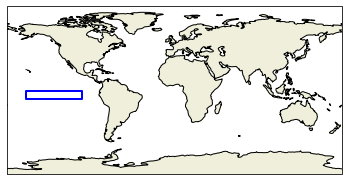

-Case - CAM6 f.e20.FHIST.f09_f09.cesm2_1.001

Variable details ->  PRECT
Precipitation mm/day 86400000.0
0001-01-01 0002-01-01


/glade/work/rneale/python/miniconda3/envs/neale_myenv/lib/python3.8/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/work/rneale/python/miniconda3/envs/neale_myenv/lib/python3.8/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)



Variable details ->  TS
Sea Surface Temperature K 1.0
0001-01-01 0002-01-01


/glade/work/rneale/python/miniconda3/envs/neale_myenv/lib/python3.8/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/work/rneale/python/miniconda3/envs/neale_myenv/lib/python3.8/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)



Variable details ->  OMEGA
Vertical Velocity pa/s 1.0


/glade/work/rneale/python/miniconda3/envs/neale_myenv/lib/python3.8/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/work/rneale/python/miniconda3/envs/neale_myenv/lib/python3.8/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)



Variable details ->  Q
Specific Humidity g/kg 1000.0


/glade/work/rneale/python/miniconda3/envs/neale_myenv/lib/python3.8/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/work/rneale/python/miniconda3/envs/neale_myenv/lib/python3.8/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)



Variable details ->  ZMDQ
Humidity Tendency due to Deep Convection g/kg 86400000.0


/glade/work/rneale/python/miniconda3/envs/neale_myenv/lib/python3.8/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/work/rneale/python/miniconda3/envs/neale_myenv/lib/python3.8/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)



Variable details ->  RVMTEND_CLUBB
Humidity Tendency due to Moist Turbulence g/kg/day 86400000.0


/glade/work/rneale/python/miniconda3/envs/neale_myenv/lib/python3.8/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/work/rneale/python/miniconda3/envs/neale_myenv/lib/python3.8/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


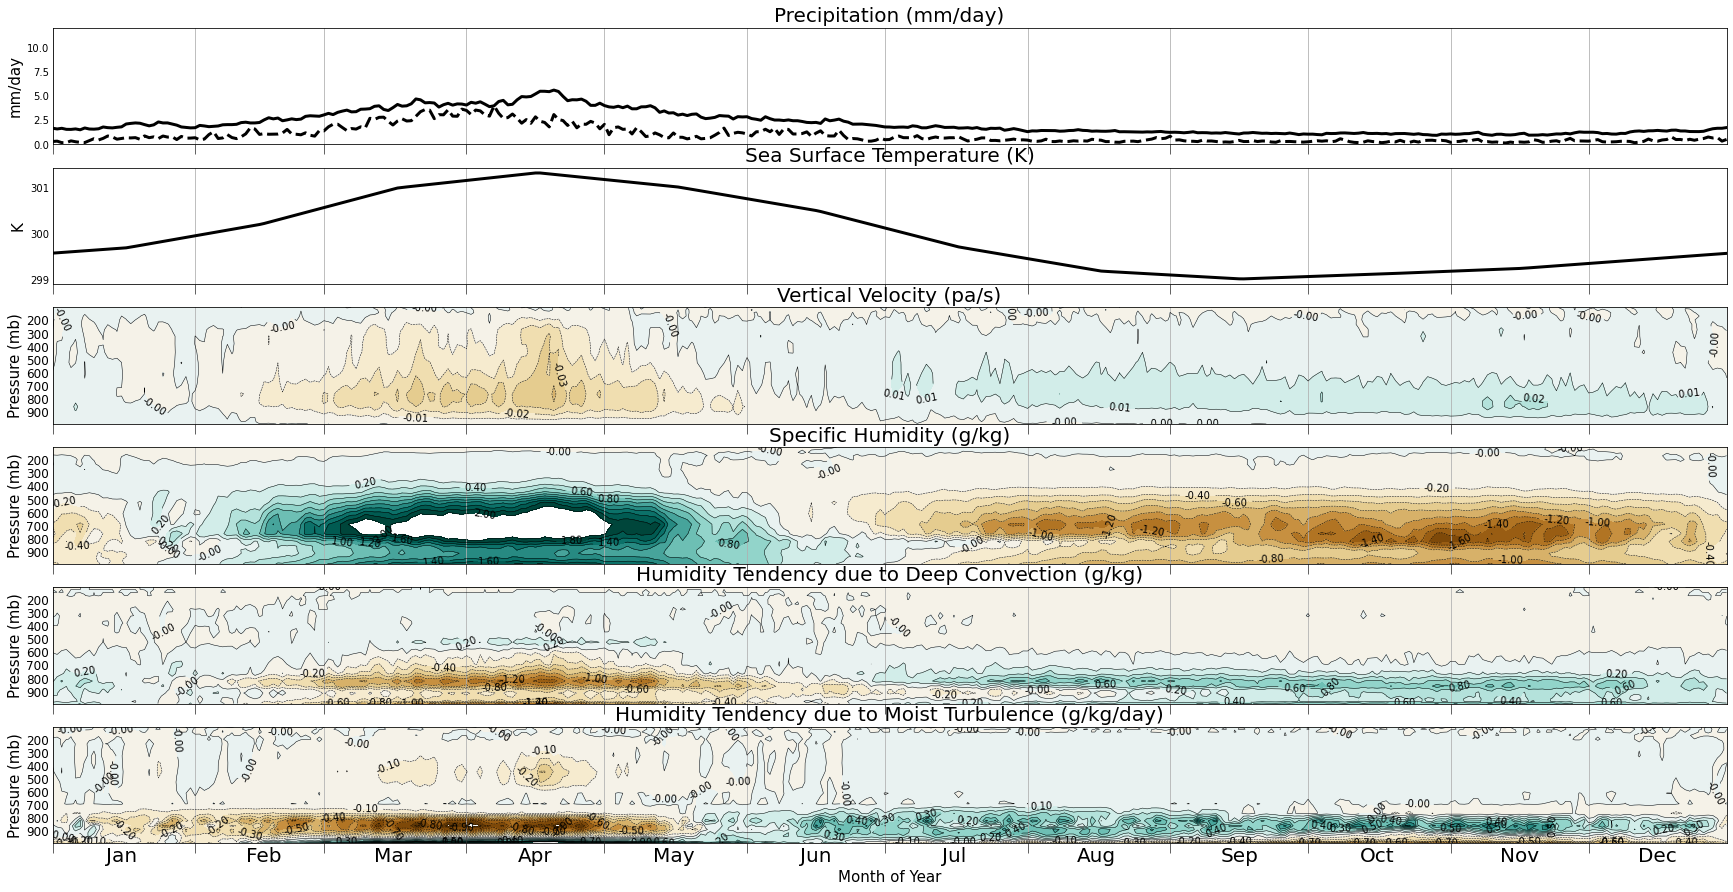

<Figure size 432x288 with 0 Axes>

In [49]:
## Derived ##

case_names = np.array(case_names)
vars_p = np.array(vars_p)

ncases = case_names.size
nvars = vars_p.size
# Region

reg_a_out = '%d-%dW_%.1f-%dN' % (360-reg_a[2],360-reg_a[3],reg_a[0],reg_a[1])
reg_a_str = '%d-%d\u00b0W %.1f-%d\u00b0N' % (360-reg_a[2],360-reg_a[3],reg_a[0],reg_a[1])

### Variables 
# Variables

vars_1d = ['TS','PRECT']

variables = {}
variables['TS'] = ['Sea Surface Temperature','K',1.,280,302,2]  
variables['PRECT'] = ['Precipitation','mm/day',86400.*1000.,280,302,2]  
variables['Q'] = ['Specific Humidity','g/kg',1000.,-2,2,0.2]  
variables['ZMDT'] = ['Temperature Tendency due to Deep Convection','K/day',86400,-5,5,1]  
variables['ZMDQ'] = ['Humidity Tendency due to Deep Convection','g/kg',86400.*1000.,-2,2,0.2] 
variables['OMEGA'] = ['Vertical Velocity','pa/s',1.,-0.1,0.1,0.01] 
variables['RVMTEND_CLUBB'] = ['Humidity Tendency due to Moist Turbulence','g/kg/day',86400*1000,-1,1,0.1] 

vars_df = pd.DataFrame.from_dict(variables, orient='index',columns=['long_name','vunits','vscale','cmin','cmax','dcont'])



## Plot map with averaging location

figm = mp.figure()

axm = figm.add_subplot(projection=ccrs.PlateCarree())

r1 = reg_a[2] if reg_a[3] <=180. else reg_a[2]-360.
r2 = reg_a[0] 
r3 = reg_a[3] if reg_a[3] <=180. else reg_a[3]-360.
r4 = reg_a[1] 


print('-- Region -> ',r1,r2,r3,r4)
print('')

extent_box = sgeom.box(r1,r2,r3,r4)

axm.add_geometries([extent_box], ccrs.PlateCarree(), facecolor='none',
                          edgecolor='blue', linewidth=2)
axm.add_feature(cfeature.LAND)
axm.add_feature(cfeature.COASTLINE)
mp.show()

fig, ax = mp.subplots(nvars,1,figsize=(30, nvars*2.5))



########################
##### CASE LOOP   ######
########################
for ic in range(ncases):
    
    case = case_names[ic]
    run = run_names[ic]

    print('-Case - '+case+' '+run)
    
    
########################  
### VARIABLE LOOP ####
########################   

    for ivar,var in enumerate(vars_p) :
    
# DF variable mete data for this variables       
        long_name = vars_df.loc[var]['long_name']
        vscale = vars_df.loc[var]['vscale']
        vunits = vars_df.loc[var]['vunits']
        cmin = vars_df.loc[var]['cmin'] ;  cmax = vars_df.loc[var]['cmax'] ;  dcont = vars_df.loc[var]['dcont'] 
        
        print()
        print('Variable details -> ',var)
        print(long_name,vunits,vscale)
    
# Read in datat
        file_in = '/glade/scratch/rneale/'+run+'/tseries/'+run+'_clim_dmeans_ts_'+var+'.nc'
        file_ptr = xr.open_dataset(file_in,engine='netcdf4')
        
        if var in vars_1d:
            print(date_range[0],date_range[1])
        
            var_in = file_ptr[var].loc[date_range[0]:date_range[1],reg_a[0]:reg_a[1],reg_a[2]:reg_a[3]] 
                 
            if var == "PRECT": 
                ofile_in = "/glade/work/rneale/data/TRMM/TRMM.PRECT.30.N-30.S_ann_anoms.nc"
                ofile_ptr = xr.open_dataset(ofile_in,engine='netcdf4')
                ovar = ofile_ptr['PRECT_ACYCLE'].loc[:,reg_a[0]:reg_a[1],reg_a[2]:reg_a[3]]     
                ovar = ovar.mean(dim=['lat','lon'])
        else :
            var_in = file_ptr[var].loc[date_range[0]:date_range[1],:,reg_a[0]:reg_a[1],reg_a[2]:reg_a[3]] 
       
#        var_in = var_in.groupby("time.dayofyear")
        
#        print(var_in)
    
# Scale avergae set time ertc.
        var_m =  var_in.mean(dim=['lat','lon'])*vscale
        time = var_m.time
        
# Offset Jan/Feb time problem
        time = time - timedelta(days=1)
        nt = time.size

# Time format
        date_form = DateFormatter("%b")
        doy = time.dt.strftime('%j')
        var_m['time'] = doy


        
        
# Filter
#        if var not in vars_1d:
#            for ii in range(0,10): #Simple multiple passes of a 1-2-1 filter
#                var_m[:,1:nt-2] = 0.25*(var_m[:,0:nt-3].values+2*var_m[:,1:nt-2].values+var_m[:,2:nt-1].values)
       
        
        
        

########################
####### PLOTTING #######
########################


        ax[ivar].set_title(long_name+' ('+vunits+')',fontsize=20)
    
# Lines at x-axis minor points + no length major ticks and no actual labels.
        ax[ivar].grid(axis = 'x', which='minor')
        ax[ivar].xaxis.set_ticklabels([])
        ax[ivar].tick_params(which='major', length=0)
    
    
# LINE OR COUTOUR PLOT #
        if var in vars_1d:
    
 #           if lrm_mean : var_m = var_m - var_m.mean(dim='time')
            ax[ivar].plot(var_m.time,var_m,lw=3,color = 'black')  
            ax[ivar].set_xlim([min(doy), max(doy)])
           
            
            if var == 'PRECT':
                ax[ivar].plot(var_m.time,ovar,lw=3,color = 'black',linestyle='dashed')  
                ax[ivar].set_ylim([0, 12])
                
            ax[ivar].set_ylabel(vunits,fontsize=15) 
        else :
    
    # Pressure levels    
            plev = np.arange(100.,1000.,100)
            lev = var_m.lev
            nlev = lev.size
            
            if (lrm_mean) :
                var_mean = var_m.mean(dim='time')
                for ipp in range(nlev):
                    var_m[:,ipp] = var_m[:,ipp] - var_mean[ipp]
            
            var_m = var_m.transpose()
        
 
## Contours
            plevels =  np.arange(cmin,cmax+dcont,dcont,dtype=np.double)
            plevels = plevels[plevels!=0]
    
            ax[ivar].invert_yaxis()
            ax[ivar].set_ylabel('Pressure (mb)',fontsize=15) 
            ax[ivar].set_yticks(plev)
            ax[ivar].set_yticklabels(plev.astype(int))
#    ax[ic].set_yticklabels(lev.astype(int),fontsize=15)
            ax[ivar].tick_params(axis="y", labelsize=12)
            
            ax[ivar].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
       

            aplot = ax[ivar].contourf(var_m.time,lev,var_m,levels=plevels,cmap='BrBG')
            aplot = ax[ivar].contour(var_m.time,lev,var_m,levels=plevels,colors='black',linewidths=0.5)
            ax[ivar].clabel(aplot, aplot.levels,fmt='%3.2f')
#           aplot = ax[ivar].contour(doy,lev,var_m,levels=[0],colors='black',linewidths=3,linestyles='dashed')
   
        ax[ivar].xaxis.set_minor_locator(mdates.MonthLocator())
        ax[ivar].xaxis.set_major_locator(mdates.MonthLocator(bymonthday=16))
        ax[ivar].tick_params(which='minor', length=10)
        



  

   


    
    mp.rcParams['xtick.labelsize']=20 # GLobal set of xtick label size

    ####### Xaxis labels (Month) for last plot only.
    ax[ivar].xaxis.set_major_formatter(date_form)
    ax[ivar].tick_params(axis="x", labelsize=20)
    ax[ivar].axes.xaxis.set_visible(True)
    ax[ivar].set_xlabel("Month of Year",fontsize=15)  


mp.show()
    ## FILE OUTPUT FOR THIS CASE ##
ptitle = case+' - '+reg_a_str
 #   mp.suptitle(ptitle,fontsize=20)
mp.savefig('daily_ts.plev_'+case+'_'+reg_a_out+'_'+date_range[0]+'_to_'+date_range[1]+'.png', dpi=300)  
    